#### Обучение трансформера c использованием сети DaBERTa:

#### Обучение и инференс моделей происходил на kaggle.com с использованием бесплатного недельного доступа к GPU блоку A100.

#### Загружаем недостающие модули:

In [1]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install wandb

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install datasets accelerate nvidia-ml-py3

  Preparing metadata (setup.py) ... - done
  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-py3-none-any.whl size=19172 sha256=2351baa583dafbbd12f89fcbaba44b296b7489381c83ad2bf058cc0aff46a78d
  Stored in directory: /root/.cache/pip/wheels/5c/d8/c0/46899f8be7a75a2ffd197a23c8797700ea858b9b34819fbf9e
Successfully built nvidia-ml-py3
Note: you may need to restart the kernel to use updated packages.


#### Импортируем модули:

In [4]:
import os
import string
import sys
import random
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import re
import datetime

import torch
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset, random_split,  RandomSampler, SequentialSampler
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence

from sklearn.metrics import accuracy_score
from torch.utils.tensorboard import summary, writer, SummaryWriter

from tqdm.notebook import tqdm


#### Устанавливаем Seed'ы:

In [5]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

import warnings
warnings.filterwarnings("ignore")

#### Задаём device:

In [6]:
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


#### Импортируем и устанавливаем дополнительно все, что необходимо:

In [7]:
!git clone https://github.com/KuzmaKhrabrov/character-tokenizer.git

Cloning into 'character-tokenizer'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 20 (delta 5), reused 10 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (20/20), 5.89 KiB | 1.96 MiB/s, done.
Resolving deltas: 100% (5/5), done.


In [8]:
sys.path.append("/kaggle/input/tools/character-tokenizer")
from charactertokenizer import CharacterTokenizer

#### Check:

In [9]:
chars = "АаБбВвГгДдЕеЁёЖжЗзИиЙйКкЛлМмНнОоПпРрСсТтУуФфХхЦцЧчШшЩщЪъЫыЬьЭэЮюЯя-h"
model_max_length = 22
tokenizer = CharacterTokenizer(chars, model_max_length)

#### Проверяем Encode:

In [10]:
example = "-буh"
tokens = tokenizer(example)
print(tokens)

{'input_ids': [0, 73, 10, 48, 74, 1], 'token_type_ids': [0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}


#### Проверяем Decode:

In [11]:
print(tokenizer.decode(tokens["input_ids"]))

[CLS]-буh[SEP]


#### Задача:

##### Необходимо обучить модель классификации букв для задачи расстановки ударения с помощью методов из библиотеки transformers.

1. Написать класс для Dataset/Dataloder и разбить данные на случайные train / test сплиты в соотношении 50:50. (1 балл)
2. Попробовать обучить одну или несколько из моделей: Bert, Albert, Deberta. Посчитать метрику Accuracy на train и test. (1 балл). При преодолении порога в Accuracy на test 0.8: (+1 балл), 0.85: (+2 балла), 0.89: (+3 балла).

#### Датасет загружен, проверяем его содержимое:

In [12]:
accents_path = '/kaggle/input/accents-dataset/all_accents.tsv'
accents_dataset = pd.read_csv(accents_path, sep = '\t', header=0, encoding='utf-8', na_values='NA')

In [13]:
accents_dataset.head()

,-де,-д^е
0,-ка,-к^а
1,-либо,-л^ибо
2,-нибудь,-ниб^удь
3,-с,-с
4,-таки,-так^и


#### Немного исследований датасета:

In [14]:
# Число примеров:
print(accents_dataset.shape[0])

1680534


In [ ]:
# Символьная длина слов
def word_length(word):
    '''Просто принимаем на вход слово и возвращаем его длину'''
    return len(word)

# Один символ
def is_one_symbol(word):
    '''Возвращаем 1, если слово имеет один символ, иначе возвращаем 0'''
    return int(len(word) == 1)

# Больше одного слова через пробел
def more_than_one_word(word):
    '''Возвращаем 1, если несколько слов в записи, иначе 0'''
    splitted = word.split(' ')
    return int(len(splitted) > 1)

# Подсчет символов ударения ^:
def count_hat(word):
    '''Считаем количество символов ^'''
    return len(re.findall(r'\^', word))

# Есть ли латинские буквы в слове
def contains_latin(word):
    '''Обрабатываем случаи наличия латинских символов (bool flag)'''
    return int(bool(re.search(r'[a-zA-Z]', word)))

# Функция для подсчета символов, которые не являются русскими буквами
def count_non_russian(word):
    '''Считаем количество не кириллицы'''
    return len(re.findall(r'[a-zA-Z]', word))

def letter_yo(word):
    '''Обрабатываем случай буквы ёЁ, она всегда угарная'''
    return int(bool(re.search(r'[ёЁ]', word)))

def error_cases(word):
    '''Обработка ошибок (ударение в слове падает на согласную букву)'''
    pattern = r'\^[бвгджзйклмнпрстфхцчшщБВГДЖЗЙКЛМНПРСТФХЦЧШЩ]'   
    matches = re.findall(pattern, word)
    return len(matches)


accents_dataset['word_length'] = accents_dataset['-де'].map(word_length)
accents_dataset['is_one_symbol'] = accents_dataset['-де'].map(is_one_symbol)
accents_dataset['more_than_one_word'] = accents_dataset['-де'].map(more_than_one_word)
accents_dataset['hat_num'] = accents_dataset['-д^е'].map(count_hat)
accents_dataset['has_latin'] = accents_dataset['-де'].map(contains_latin)
accents_dataset['num_non_russian'] = accents_dataset['-де'].map(count_non_russian)
accents_dataset['error_cases'] = accents_dataset['-д^е'].map(error_cases)
accents_dataset['is_Ёё'] = accents_dataset['-де'].map(letter_yo)

In [16]:
# Максимальное и среднее число символов в слове:
word_max_length = accents_dataset['word_length'].max()
print(f"Максимальное число символов в слове: {word_max_length}")

# Максимальное и среднее число символов в слове:
word_mean_length = accents_dataset['word_length'].mean()
print(f"Среднее число символов в слове: {word_mean_length}")

Максимальное число символов в слове: 56
Среднее число символов в слове: 10.641052189363618


#### Посмотрим более пристально на ударения:

In [17]:
accents_count_max = accents_dataset['hat_num'].max()
print(f"Максимальное число ударений в слове: {accents_count_max}")

zero_accents_num = accents_dataset[accents_dataset['hat_num'] == 0].shape[0]
print(f"Количество случаев отсутствия ударений в словах: {zero_accents_num}")

Максимальное число ударений в слове: 1
Количество случаев отсутствия ударений в словах: 507


Ошибок нет, где у нас больше одного ударения. Однако у нас целых 507 случаев отсутствия ударений в словах:

In [18]:
accents_dataset[accents_dataset['hat_num'] == 0].head(10)

,-де,-д^е,word_length,is_one_symbol,more_than_one_word,hat_num,has_latin,num_non_russian,error_cases,is_Ёё
3,-с,-с,2,0,0,0,0,0,0,0
16107,ай,ай,2,0,0,0,0,0,0,0
16172,айвингхо,айвингхо,8,0,0,0,0,0,0,0
24766,алмондсбери,алмондсбери,11,0,0,0,0,0,0,0
27255,ам,ам,2,0,0,0,0,0,0,0
29041,амка,амка,4,0,0,0,0,0,0,0
35185,анка,анка,4,0,0,0,0,0,0,0
42254,анька,анька,5,0,0,0,0,0,0,0
62526,б,б,1,1,0,0,0,0,0,0
75305,бедерный,бедерный,8,0,0,0,0,0,0,0


Возможно, это ошибка разметки или какие-то части слов. Но где-то это справедливо ввиду отсутствия гласных букв в словах. Подобные сэмплы могут запутать модель, но их количество в целом и незначительно в сравнении с общим числов сэмплов в обучении.

#### Нерусская раскладка:

In [19]:
accents_count_latin_max = accents_dataset['num_non_russian'].max()
print(f"Максимальное число нерусских символов в слове: {accents_count_latin_max}")

accents_count_latin = accents_dataset[accents_dataset['num_non_russian'] > 0].shape[0]
print(f"Количество сэмплов, где число нерусских символов больше 0: {accents_count_latin}")

Максимальное число нерусских символов в слове: 2
Количество сэмплов, где число нерусских символов больше 0: 14


In [20]:
accents_dataset[accents_dataset['num_non_russian'] > 0]

,-де,-д^е,word_length,is_one_symbol,more_than_one_word,hat_num,has_latin,num_non_russian,error_cases,is_Ёё
116704,буhалтер,буh^алтер,8,0,0,1,1,1,0,0
116705,буhалтер-калькулятор,буh^алтер-калькулятор,20,0,0,1,1,1,0,0
116706,буhалтер-ревизор,буh^алтер-ревизор,16,0,0,1,1,1,0,0
116707,буhалтерия,буhалт^ерия,10,0,0,1,1,1,0,0
116708,буhалтерски,буh^алтерски,11,0,0,1,1,1,0,0
116709,буhалтерский,буh^алтерский,12,0,0,1,1,1,0,0
116710,буhалтерша,буh^алтерша,10,0,0,1,1,1,0,0
620314,лимасcольский,лимасc^ольский,13,0,0,1,1,1,0,0
1018887,по-буhалтерски,по-буh^алтерски,14,0,0,1,1,1,0,0
1133176,прдjети,прдjети,7,0,0,0,1,1,0,0


Что ж, есть и такие сэмплы, но благо их тоже не очень-то и много.

#### Посмотрим на распределения слов по выделенным параметрам:

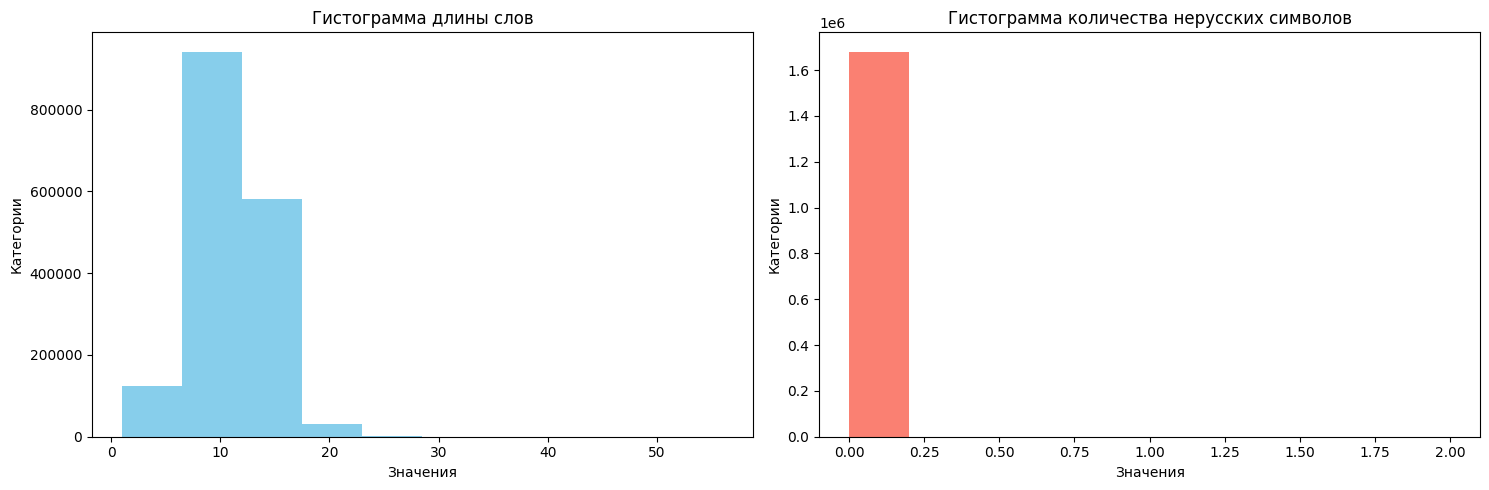

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].hist(accents_dataset['word_length'], color='skyblue')
axs[0].set_title('Гистограмма длины слов')
axs[1].hist(accents_dataset['num_non_russian'], color='salmon')
axs[1].set_title('Гистограмма количества нерусских символов')
for ax in axs:
    ax.set_xlabel('Значения')
    ax.set_ylabel('Категории')

plt.tight_layout()
plt.show()

In [22]:
print(f"95-квантиль: {np.quantile(accents_dataset['word_length'].values, q = 0.95)}")

95-квантиль: 16.0


In [23]:
len(accents_dataset[accents_dataset['word_length'] > 20])

4477

Думаю 4500 длинных слов можно отбросить

In [24]:
accents_dataset = accents_dataset[accents_dataset['word_length'] < 20]

Итак, предварительный анализ показывает, что существуют особые сэмплы, которые могут повлиять на обобщающую способность модели. Однако их количество не такое уж и большое и, в целом, такие примеры как одна согласная могут быть довольно-таки полезными. По необходимости, отфильтруем данные позже.

Как вариант иностранные символы из латинской раскладки можно заменить транслитерацией на русские символы или, например, неизвестные символы (отличающиеся от "-") вообще убрать или заменить на другой символ. 

#### Еще хочется посмотреть, есть ли сэмплы, в которых случайно расставлены ударения на согласную букву и сэмплы, содержащие букву ёЁ, чтобы не учить модель на них:

In [25]:
print(f"Количество сэмплов с буквой Ёё: {accents_dataset[accents_dataset['is_Ёё'] != 0].shape[0]}")

print(f"Количество сэмплов с ударениям на согласную: {accents_dataset[accents_dataset['error_cases'] != 0].shape[0]}")

Количество сэмплов с буквой Ёё: 0
Количество сэмплов с ударениям на согласную: 0


Итак, букв Ёё и ошибок с ударением на согласную нет.

#### Всё же попробуем заменит английские символы транслитерацией:

In [ ]:
latin_to_russian_needed = {
    'c': 'с', 'h': 'г', 'j': 'ъ', 'g': 'г'
}

def transliterate(text):
    '''Делаем транслитерацию найденных латинских букв и символов'''
    return ''.join(latin_to_russian_needed.get(char, char) for char in text)

accents_dataset['words_upd'] = accents_dataset['-де'].map(transliterate)

In [27]:
accents_dataset[accents_dataset['num_non_russian'] > 0].head()

,-де,-д^е,word_length,is_one_symbol,more_than_one_word,hat_num,has_latin,num_non_russian,error_cases,is_Ёё,words_upd
116704,буhалтер,буh^алтер,8,0,0,1,1,1,0,0,бугалтер
116706,буhалтер-ревизор,буh^алтер-ревизор,16,0,0,1,1,1,0,0,бугалтер-ревизор
116707,буhалтерия,буhалт^ерия,10,0,0,1,1,1,0,0,бугалтерия
116708,буhалтерски,буh^алтерски,11,0,0,1,1,1,0,0,бугалтерски
116709,буhалтерский,буh^алтерский,12,0,0,1,1,1,0,0,бугалтерский


#### Уберем, где нет ударений:

In [28]:
accents_dataset = accents_dataset[accents_dataset['hat_num'] > 0]

#### Итоговый датасет после некоторых преобразований:

In [29]:
accents_dataset.shape

(1671254, 11)

In [30]:
accents_dataset.head(10)

,-де,-д^е,word_length,is_one_symbol,more_than_one_word,hat_num,has_latin,num_non_russian,error_cases,is_Ёё,words_upd
0,-ка,-к^а,3,0,0,1,0,0,0,0,-ка
1,-либо,-л^ибо,5,0,0,1,0,0,0,0,-либо
2,-нибудь,-ниб^удь,7,0,0,1,0,0,0,0,-нибудь
4,-таки,-так^и,5,0,0,1,0,0,0,0,-таки
5,-то,-т^о,3,0,0,1,0,0,0,0,-то
6,­вычеркнуть,­в^ычеркнуть,11,0,0,1,0,0,0,0,­вычеркнуть
7,а,^а,1,1,0,1,0,0,0,0,а
8,а-конто,а-к^онто,7,0,0,1,0,0,0,0,а-конто
9,а-ля,а-л^я,4,0,0,1,0,0,0,0,а-ля
10,а-мольный,а-м^ольный,9,0,0,1,0,0,0,0,а-мольный


#### Теперь нужно подготовить данные для обучения

Предполагается, что есть смысл разделить слово на токены, причём каждая буква будет являться токеном. Далее можно присвоить каждому токену метку 1 или 0 в зависимости от того, является ли данный токен ударным или нет и выйти на своего рода задачу бинарной классификации для каждого токена.

UPD: позднее от данной идеи было решено отказаться в пользу классификации ударной позиции в слове. Посколько метка 1 одна, а меток 0 (безударная) может быть немало, модель может начать минимизировать лосс с приоритетом по безударным позициям, что не есть хорошо.

Однако посчитано и посчитано, перейти к задаче классификации не составит особого труда!

In [ ]:
def get_marked_dict(dataset = accents_dataset,
			input_column = 'words_upd',
			predict_column = '-д^е'):
	
	'''
	Функция, реализующая логику выделения ударного токена в слове
	
	Параметры:
	-dataset: выделенный датасет (default: accents_dataset)
	-input_column: колонка датасета, которую будем обрабатывать (default: 'words_upd')
	-predict_column: колонка датасета, где будем искать ударение (default: '-д^е')
	'''
	
	words = dataset[input_column].values
	words_accents = dataset[predict_column].values
	inputs = [word for word in words]
	labels = []
	
	for word, accents in tqdm(zip(words, words_accents)):
		label = [0] * (len(word) + 2)
		for i, char in enumerate(accents):
			if char == '^':
				label[i+1] = 1
				
		labels.append(label)
	return {"input_words" : inputs,
		"labels" : labels}
		
words_labels = get_marked_dict()

0it [00:00, ?it/s]

In [ ]:
def get_example(dict = words_labels,
                idx = 0):
    '''Получаем экземпляр после обработки'''
    print(words_labels['input_words'][idx], words_labels['labels'][idx])
    
get_example(idx = 1001)

абердинского [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
def convert_to_tokens(example):
    '''Конвертер экземпляра в токен'''
    result = tokenizer.convert_ids_to_tokens(example)
    return result

Вроде как размечено корректно. Создаем torc.utils.data.Dataset из словаря:

In [ ]:
class AccentDataset(Dataset):
	
	def __init__(self, words_labels = words_labels,
				tokenizer = tokenizer,
				max_len = 22):
		
		'''
		Конструктор датасета ударений, который мы и будем подавать в сеть
		
		Параметры:
		-self
		-words_labels: метки для ударности позиций (default: words_labels, полученные раннее)
		-tokenizer: токенизатор (default: tokenizer из репозитория)
		-max_len: ограничиваем максимальную длину слова (default: 22)
		'''
		self.data = words_labels
		self.tokenizer = tokenizer
		self.max_model_length = max_len
		
	def __len__(self):
		return len(self.data['input_words'])
	
	def __getitem__(self, idx, idx_to_token = False):
		input_word, accent_labels = self.data['input_words'][idx], self.data['labels'][idx]
		
		encoding = self.tokenizer.encode_plus(
			input_word,
			add_special_tokens=True,
			max_length=self.max_model_length,
			padding='max_length',
			truncation=True,
			return_attention_mask=True,
			return_tensors='pt',
		)
		
		input_ids = encoding['input_ids'].flatten()
		attention_mask = encoding['attention_mask'].flatten()
		token_type_ids = encoding['token_type_ids'].flatten()

		labels = torch.tensor(accent_labels, dtype=torch.long)
		padding_length = self.max_model_length - labels.size(0)
		idx = np.where(labels == 1)[0]
		if len(idx) == 0:
			print(input_ids)
			print(labels)
			print(convert_to_tokens(input_ids.tolist()))
		label = torch.tensor(idx)

		if idx_to_token == True:
			return {
				'input_ids': self.tokenizer.convert_ids_to_tokens(input_ids),
				'attention_mask': attention_mask,
				'token_type_ids': token_type_ids,
				'labels': torch.tensor(idx[0], dtype=torch.long)
				}
		return {
				'input_ids': input_ids,
				'attention_mask': attention_mask,
				'token_type_ids': token_type_ids,
				'labels': torch.tensor(idx[0], dtype=torch.long)
				}
	
	
words_labels_dataset = AccentDataset()

#### Check:

In [34]:
words_labels_dataset[168]['labels']

tensor(5)

In [35]:
len(words_labels_dataset)

1671254

In [36]:
words_labels_dataset[1001]

{'input_ids': tensor([ 0,  8, 10, 18, 42, 16, 26, 36, 44, 30, 38, 14, 38,  1,  4,  4,  4,  4,
          4,  4,  4,  4]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'labels': tensor(6)}

In [37]:
words_labels_dataset.__getitem__(0, idx_to_token = True)

{'input_ids': ['[CLS]',
  '-',
  'к',
  'а',
  '[SEP]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]'],
 'attention_mask': tensor([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'labels': tensor(3)}

Всё корректно. Теперь нужно написать функцию получения датасетов для train и для test.

In [ ]:
def get_datasets(dataset_cls = AccentDataset,
			max_len = 22, # 99% слов ниже этой длины по символам
			data = words_labels,
			tokenizer = tokenizer,
			train_size = 0.5):
	'''
	Функция get_datasets() возвращает train и test датасеты на основе конструктора AccentDataset, делая train_test_spilt
	
	Параметры функции:
	-dataset_cls: класс датасета, который мы будем передвавать в функцию и чей конструктор мы будем вызывать (default: AccentDataset)
	-max_ken: максимальная длина последовательности токенов (решил взять 22, так как это 95% квантиль распределения слов по длинам)
	-data: данные (default: words_labels)
	-tokenizer: токенизатор (default: tokenizer)
	-train_size: размер train выборки для сплита (default: 0.5 из задания)
	'''
	# Вызов конструктора датасета
	dataset = dataset_cls(words_labels = data,
				tokenizer = tokenizer,
				max_len = max_len)
	
	# Устанавливаем размеры
	train_size = int(train_size * len(dataset))
	test_size = len(dataset) - train_size
	train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

	# Возвращаем датасеты train + test		
	return train_dataset, test_dataset

train_dataset_, test_dataset = get_datasets()
	

#### Check:

In [40]:
len(train_dataset_), len(test_dataset)

(835627, 835627)

#### Проверим тренировочный сэмпл:

In [41]:
train_dataset_[2]

{'input_ids': tensor([ 0, 24,  8, 40,  8, 52,  8, 36, 36, 48, 70,  1,  4,  4,  4,  4,  4,  4,
          4,  4,  4,  4]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'labels': tensor(4)}

In [42]:
print(convert_to_tokens(train_dataset_[2]['input_ids'].tolist()))

['[CLS]', 'з', 'а', 'п', 'а', 'х', 'а', 'н', 'н', 'у', 'ю', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [43]:
train_dataset_[2]['labels']

tensor(4)

#### Проверим тестовый сэмпл:

In [44]:
test_dataset[2]

{'input_ids': tensor([ 0, 48, 54, 18, 40, 32, 72, 70, 46,  1,  4,  4,  4,  4,  4,  4,  4,  4,
          4,  4,  4,  4]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'labels': tensor(6)}

In [45]:
print(convert_to_tokens(test_dataset[2]['input_ids'].tolist()))

['[CLS]', 'у', 'ц', 'е', 'п', 'л', 'я', 'ю', 'т', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [46]:
test_dataset[2]['labels']

tensor(6)

Всё работает!

#### Теперь нужно сделать train_val_split:

In [ ]:
def train_val_split(dataset = train_dataset_,
				train_size = 0.9):
	
	'''
	Функция для создания искомого тренировочного и валидационного множества

	Параметры:
	-dataset: тренировочный датасет, который будет разбиваться на train x val (default: train_dataset_)
	-train_size: размер искомового тренировочного датасета от передаваемого (default: 0.9)
	'''
	
	# Объявляем размеры train x val
	train_size = int(train_size * len(dataset))
	val_size = len(dataset) - train_size
	
	# Делаем сплит и возвращаем тренировочный и тестовый датасеты
	train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
	return train_dataset, val_dataset

train_dataset, val_dataset = train_val_split()

#### Check:

In [48]:
len(train_dataset), len(val_dataset)

(752064, 83563)

In [49]:
train_dataset[2]['labels']

tensor(10)

In [ ]:
def get_loaders(train_dataset = train_dataset,
				val_dataset = val_dataset,
			test_dataset = test_dataset,
			shuffle_train = True,
			shuffle_val = False,
				shuffle_test = False,
			batch_size = 128):
	'''
	Функция get_loaders() для получения train, val и test даталоадеров

	Параметры:
	-train_dataset: тренировочный датасет (default: train_dataset)
	-val_dataset: валидационный датасет (default: val_dataset)
	-test_dataset: тестовый датасет (default: test_dataset)
	-shuffle_train: флаг перемешивания для train (default: True)
	-shuffle_val: флаг перемешивания для val (default: False)
	-shuffle_test: флаг перемешивания для test (default: False)
	-batch_size: размер батча данных (default: 128)
	'''
	
	# train_dataloader
	train_dataloader = DataLoader(
			train_dataset,   
			batch_size = batch_size,
			shuffle = shuffle_train,
		)

	# validation_dataloader
	validation_dataloader = DataLoader(
			val_dataset, 
			batch_size = batch_size,
			shuffle = shuffle_val,
		)
	
	# test_dataloader
	test_dataloader = DataLoader(
			test_dataset, 
			batch_size = batch_size,
			shuffle = shuffle_test,
		)
	
	# Возвращаем даталоадеры
	return train_dataloader, validation_dataloader, test_dataloader

train_dataloader, validation_dataloader, test_dataloader = get_loaders()


#### Check:

In [52]:
train_dataloader.dataset[0]

{'input_ids': tensor([ 0, 12, 18, 46, 18, 42, 26, 36,  8, 42, 36, 38, 34,  1,  4,  4,  4,  4,
          4,  4,  4,  4]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'labels': tensor(8)}

In [53]:
validation_dataloader.dataset[0]

{'input_ids': tensor([ 0, 42,  8, 44, 56, 18, 44, 64, 12,  8, 18, 34, 64,  1,  4,  4,  4,  4,
          4,  4,  4,  4]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'labels': tensor(2)}

#### Check итерирования:

In [54]:
for i, batch in enumerate(tqdm(train_dataloader)):
#     pass
    print(batch['input_ids'][0])
    print(len(batch['attention_mask'][0]))
    print(batch['labels'][0])
    print(convert_to_tokens(batch['input_ids'][0].tolist()))
    if i == 0:
        break

  0%|          | 0/5876 [00:00<?, ?it/s]

tensor([ 0, 40, 42, 26, 52, 32, 18, 44, 46, 36, 18, 46, 18,  1,  4,  4,  4,  4,
         4,  4,  4,  4])
22
tensor(10)
['[CLS]', 'п', 'р', 'и', 'х', 'л', 'е', 'с', 'т', 'н', 'е', 'т', 'е', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


#### Готовимся обучать... В этот раз DeBERTa модель!

In [ ]:
from transformers import DebertaForSequenceClassification, Trainer, TrainingArguments

# Импортируем модель для классификации послеждовательностей
model = DebertaForSequenceClassification.from_pretrained("microsoft/deberta-base", num_labels=20)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Перебрасываем модель на device
model.to(device)


config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/559M [00:00<?, ?B/s]

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DebertaForSequenceClassification(
  (deberta): DebertaModel(
    (embeddings): DebertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=0)
      (LayerNorm): DebertaLayerNorm()
      (dropout): StableDropout()
    )
    (encoder): DebertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaLayer(
          (attention): DebertaAttention(
            (self): DisentangledSelfAttention(
              (in_proj): Linear(in_features=768, out_features=2304, bias=False)
              (pos_dropout): StableDropout()
              (pos_proj): Linear(in_features=768, out_features=768, bias=False)
              (pos_q_proj): Linear(in_features=768, out_features=768, bias=True)
              (dropout): StableDropout()
            )
            (output): DebertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): DebertaLayerNorm()
              (dropout): StableDropout()
            )
          )
          (

#### Нашел возможность логирования с помощью wandb.ai (Weights and Biases):

#### Аргументы:

In [ ]:
import wandb
wandb.login(key='### HERE_WAS_MY_API_KEY ###')

wandb.init(project='DaBERTa_Accents_GO', config={
    'learning_rate': 3e-5,
    'epochs': 15,
    'batch_size': 128,
})


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: 4ervonec19 (4ervonec19-bauman-moscow-state-technical-university). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.18.3
wandb: Run data is saved locally in /kaggle/working/wandb/run-20241109_232407-y4ak9gnv
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run bright-cherry-1
wandb: ⭐️ View project at https://wandb.ai/4ervonec19-bauman-moscow-state-technical-university/DaBERTa_Accents_GO
wandb: 🚀 View run at https://wandb.ai/4ervonec19-

In [ ]:
from sklearn.metrics import accuracy_score


def compute_metrics(eval_pred):
    '''Функция подсчета метрики accuracy'''
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        'accuracy': accuracy_score(labels, predictions)
    }


'''Аргументы, передаваемые в wandb.ai обертку'''
training_args = TrainingArguments(
    output_dir='./results', # Путь результатов
    evaluation_strategy='epoch', # Валидация через эпоху
    save_strategy='epoch', # Созранение через эпоху
    learning_rate=wandb.config['learning_rate'], # Шаг сходимости из config
    per_device_train_batch_size=wandb.config['batch_size'], # Размер train-батча из config
    per_device_eval_batch_size=wandb.config['batch_size'], # Размер val-батча из config
    num_train_epochs=wandb.config['epochs'], # Число эпох из config
    weight_decay=0.01, # Weight decay
    logging_dir='./logs', # Папка для логов
    logging_steps=10,
    gradient_accumulation_steps=2, # Шагов накопления градиентов
    load_best_model_at_end=True, 
    metric_for_best_model='accuracy', # Метрика отбора лучше модели 
    save_total_limit=2, # Сколько моделей будем сохранять
    report_to='wandb'
)

#### Train:

In [ ]:
'''Объявление trainer в виде конструктора'''
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset, 
    compute_metrics=compute_metrics
)

In [ ]:
'''Обучение модели'''
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.395500,0.330352,0.879923
2,0.241200,0.228939,0.913263
3,0.226100,0.185049,0.931620
4,0.174700,0.163128,0.941948
5,0.155500,0.143957,0.948685
6,0.121100,0.133725,0.953676
7,0.124600,0.126087,0.957589
8,0.109200,0.119399,0.960916
9,0.089500,0.116117,0.963417
10,0.091300,0.113263,0.964769


TrainOutput(global_step=44070, training_loss=0.16563484262576145, metrics={'train_runtime': 32025.1183, 'train_samples_per_second': 352.254, 'train_steps_per_second': 1.376, 'total_flos': 1.4863728296710656e+17, 'train_loss': 0.16563484262576145, 'epoch': 15.0})

In [60]:
wandb.finish()

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:           eval/accuracy ▁▄▅▆▆▇▇▇███████
wandb:               eval/loss █▅▃▃▂▂▂▁▁▁▁▁▁▁▁
wandb:            eval/runtime ▁▂▁▁▁▂▃▆▇▅▅▅███
wandb: eval/samples_per_second █▇███▇▆▃▂▄▄▄▁▁▁
wandb:   eval/steps_per_second █▇███▇▆▃▂▄▄▄▁▁▁
wandb:             train/epoch ▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇███
wandb:       train/global_step ▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇███
wandb:         train/grad_norm ██▆▃▄▃▂▂▁▂▃▂▃▃▂▃▂▃▂▂▃▁▃▄▂▅▆▂▂▃▂▁▁▃▃▂▃▁▃▂
wandb:     train/learning_rate ████▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁
wandb:              train/loss ██▃▃▃▂▂▂▂▂▂▂▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: 
wandb: Run summary:
wandb:            eval/accuracy 0.96866
wandb:                eval/loss 0.1141
wandb:             eval/runtime 86.6476
wandb:  eval/samples_per_second 964.4
wandb:    eval/steps_per_second 7.536
wandb:               total_flos 1.4863728296710656e+17
wandb:      

#### Ссылка на логирование:

https://wandb.ai/4ervonec19-bauman-moscow-state-technical-university/DaBERTa_Accents_GO?nw=nwuser4ervonec19